In [34]:
using SelfConsistentHartreeFock, SecondQuantizedAlgebra
using MatrixEquations, UnPack, LinearAlgebra
import SecondQuantizedAlgebra as SQA
using Symbolics

## System
$$
H=-\Delta d^\dagger a + k d^\dagger d^\dagger a a + F (d^\dagger + a)
$$

In [35]:
h = FockSpace(:cavity)

@qnumbers a::Destroy(h)
@variables F::Real Δ::Real K::Real κ::Real

H = -Δ * a' * a + K * (a'^2 * a^2) + F * (a' + a)

(-Δ*(a′*a)+K*(a′*a′*a*a)+F*(a′)+F*(a))

## Fluctuations
We assume the driven modes $a$ to have a large coherent population $\alpha$ with small quantum fluctuations $d$ on top, so we write $a = \alpha + d$.
$$
\begin{align}
H_{\rm lin}&=(-\alpha  \Delta +2 K |\alpha|^2 \alpha+F)  d^{\dagger }
+(- \alpha^* \Delta + 2 K |\alpha|^2 \alpha ^* +F)d\\
H_{\rm higher order}&=(-\Delta +4 K  |\alpha|^2 ) d^{\dagger } d
+\alpha ^2 K d^{\dagger } d^{\dagger }
+K \left(\alpha ^*\right)^2 d d
+2 K \alpha ^* d^{\dagger } d d
+2 \alpha  K d^{\dagger } d^{\dagger } d
+K d^{\dagger } d^{\dagger } d d
\end{align}
$$

## Hartree-Fock approximation 

We apply the Hartree-Fock approximation to the higher order terms, which consists in replacing products of operators by products of operators and their expectation values:
$$
\begin{align}
d^{\dagger } d^{\dagger } d d
&\approx 4n d^{\dagger } d + m^* d d + m d^{\dagger } d^{\dagger }\\
d^\dagger d d
&\approx 2n d + m d^\dagger\\
\end{align}
$$
such that, up to additive constants (which only shift the zero of energy), the higher order terms become quadratic:
$$
\begin{align}
H_{\rm HF}&=(-\Delta +4 K  |\alpha|^2 +4 K n) d^{\dagger } d
+K (\alpha ^2 +  m) d^{\dagger } d^{\dagger }
+K( \left(\alpha ^*\right)^2 +m^*) d d
\end{align}
$$
Here, we defined $\langle d^{\dagger } d\rangle=n \in \mathbb{R}$ and $\langle d d\rangle = m  \in \mathbb{C}$. The linear terms instead becomes
$$
\begin{align}
H_{\rm lin}&=
(-\alpha  \Delta +2 K |\alpha|^2 \alpha  +2 K m \alpha ^*+4 K n \alpha +F)  d^{\dagger }
+(-\Delta  \alpha ^*+2 K |\alpha|^2  \alpha ^*+2 \alpha K m^*+4 n K  \alpha ^*+F)d
\end{align}
$$

In [36]:
sys = HartreeFockSystem(H, [a], [κ])
collect_dict(sys.H)

Dict{Any, Any} with 6 entries:
  (a′*a)  => -Δ + 4K*⟨a′*a⟩ + 4K*⟨a⟩*⟨a′⟩
  (a*a)   => K*⟨a′*a′⟩ + K*(⟨a′⟩^2)
  a       => F - ⟨a′⟩*Δ + 2K*⟨a⟩*⟨a′*a′⟩ + 4K*⟨a′⟩*⟨a′*a⟩ + 2K*⟨a⟩*(⟨a′⟩^2)
  (a′*a′) => K*⟨a*a⟩ + K*(⟨a⟩^2)
  a′      => F - ⟨a⟩*Δ + 4K*⟨a⟩*⟨a′*a⟩ + 2K*⟨a′⟩*⟨a*a⟩ + 2K*(⟨a⟩^2)*⟨a′⟩
  1.0     => F*⟨a⟩ + F*⟨a′⟩ - ⟨a⟩*⟨a′⟩*Δ + K*(⟨a⟩^2)*(⟨a′⟩^2)

We can rewrite the Hartree-Fock Hamiltonian in matrix (Numba) form:
$$
H_{\rm HF}=\frac{1}{2} \Psi^\dagger 
\begin{pmatrix} A & B \\ B^* & d^T \end{pmatrix}
\Psi 
\quad\text{with}\quad
\Psi =\begin{pmatrix} d \\ d^\dagger \end{pmatrix}
$$
where $A=d^\dagger$ is hermitian and $B=B^T$ is symmetric. In our case, they are given by 
$$
\begin{align}
A&=-\Delta +4 K  |\alpha|^2 +4 K n\\
B&=2K (\alpha ^2 +  m)\\
\end{align}
$$

In [37]:
sys.dynamical_matrix.A |> display
sys.dynamical_matrix.B |> display

1×1 Matrix{Num}:
 -Δ + 4K*⟨a′*a⟩ + 4K*⟨a⟩*⟨a′⟩

1×1 Matrix{Num}:
 2(K*⟨a*a⟩ + K*(⟨a⟩^2))

Introduce the bosonic symplectic matrix $\Sigma=\mathrm{diag}(I,-I)$.
In Heisenberg–Langevin form with Markov damping rates $\kappa_i$ (pack them in $K\equiv \mathrm{Diag}(\kappa_1,\dots,\kappa_N))$:
$$
\dot \Psi = M\Psi + \Xi
 \qquad
M = -i\Sigma\mathcal{H} - \tfrac{1}{2}
\begin{pmatrix} K & 0\\ 0 & K \end{pmatrix}.
$$
Explicitly,
$$
M=\begin{pmatrix}
-iA-\tfrac12 K & -iB \\
i B^* & i A^T-\tfrac12 K
\end{pmatrix}.
$$
A steady state exists if all eigenvalues of $M$ have negative real parts (stability). For independent thermal baths with occupancies $\bar n_i$,
$$
\Xi = \binom{\sqrt{K},d^{\rm in}}{\sqrt{K},d^{\rm in,\dagger}},\quad
\langle d^{\rm in}(t),d^{\rm in,\dagger}(t')\rangle=(\bar n+1)\delta(t-t'), \quad
\langle d^{\rm in,\dagger}(t),d^{\rm in}(t')\rangle=\bar n\delta(t-t'),
$$
which gives the (white) diffusion matrix
$$
D=\begin{pmatrix}
K(\bar n+1) & 0\\
0 & K\bar n
\end{pmatrix}.
$$
Here $\bar n=\mathrm{Diag}(\bar n_1\dots\bar n_N)$. Zero temperature: set $\bar n=0.$ Define the normally-ordered correlation matrix
$$
C\equiv\langle \Psi,\Psi^\dagger\rangle
=\begin{pmatrix}
\langle d,d^\dagger\rangle & \langle d,d\rangle\\
\langle d^\dagger d^\dagger\rangle & \langle d^\dagger d\rangle
\end{pmatrix}
=\begin{pmatrix}
I + N^\top & M_{an}\\
M_{an}^\dagger & N
\end{pmatrix},
$$
where $N_{ij}=\langle d_j^\dagger d_i\rangle$ and $(M_{an})_{ij}=\langle d_i d_j\rangle$.
Then (G) satisfies the continuous-time Lyapunov equation
$$
\boxed{\quad M C + CM^\dagger + D = 0 \quad}
$$
Solve this once (no iteration) to get all steady-state second moments. Extract:
$$
N = C_{22}, \qquad M_{an}=C_{12}.
$$

In [38]:
p = Dict(F => 0.01, Δ => -0.01, K => 0.001, κ => 0.01)
problem = IterativeProblem(sys, p)

IterativeProblem

In [39]:
α = ComplexF64[1.0+1im, 0.0, 0.0]
@unpack M, D = problem.dynamical_matrix;
_M = M(α)
_D = D(α)
_M |> display
_D

2×2 Matrix{ComplexF64}:
 -0.005-0.018im   0.004+0.0im
  0.004+0.0im    -0.005+0.018im

2×2 Matrix{Float64}:
 0.01  0.0
 0.0   0.0

Notice that if any eigenvalue of $M$ has a positive real part, the Lyapunov equation has no solution. This is consistent with the fact that in this case the system has no steady state.

In [40]:
eigvals(_M) |> sum

-0.009999999999999998 + 0.0im

In [41]:
_C1 = lyap(_M, _D)
_C2 = lyapc(_M, _D)
@show _C1 ≈ _C2
_C2

_C1 ≈ _C2 = true


2×2 Matrix{ComplexF64}:
 1.02402+0.0im        0.03003-0.108108im
 0.03003+0.108108im  0.024024+0.0im

We can perform some quick checks:
* $C_{11}-I = C_{22}^\top$ (bosonic commutation relations)
* $n(n+1) > |m|^2.$ (uncertainty relation)

In [42]:
n = _C2[2,2] |> real
m = _C2[1,2]
@show _C2[1,1] - _C2[2,2] 
@show n*(n+1) > abs(m)^2 
@show _C2[1,2] ≈ conj(_C2[2,1])

_C2[1, 1] - _C2[2, 2] = 1.0000000000000007 + 0.0im
n * (n + 1) > abs(m) ^ 2 = true
_C2[1, 2] ≈ conj(_C2[2, 1]) = true


true

In [43]:
α0 = ComplexF64[rand(ComplexF64), 0.0, 0.0]
fixed_point(problem, α0)

SelfConsistentHartreeFock.Result(ComplexF64[-0.8733123179538897 + 0.00291133185801667im], [0.00527460331876267], ComplexF64[-0.04783878511726507 - 0.019405507930888407im])

In [44]:
Δsweep = range(-0.01, 0.03, 101)
Dampening = 0.2
MaxIter = 10000
ConvergenceMetricThreshold = 1e-12
results_up = parameter_sweep(problem, Δ, Δsweep, α0)
results_down = parameter_sweep(problem, Δ, reverse(Δsweep), α0; Dampening, MaxIter, ConvergenceMetricThreshold);

In [45]:
amplitude_up = map(results_up) do result
    result.αs[1] |> norm
end
amplitude_down = map(results_down) do result
    result.αs[1] |> norm
end

fluctuation_up = map(results_up) do result
    result.ns[1]
end
fluctuation_down = map(results_down) do result
    result.ns[1]
end

anomalous_up = map(results_up) do result
    result.ms[1] |> norm
end
anomalous_down = map(results_down) do result
    result.ms[1] |> norm
end;

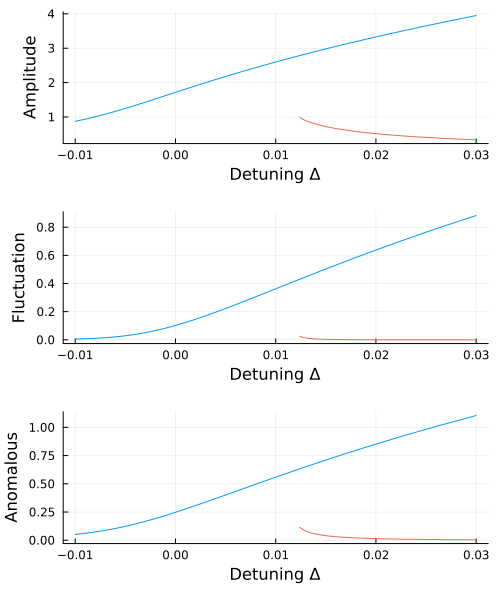

In [ ]:
using Plots
l = length(amplitude_down)
plt1 = plot(Δsweep, amplitude_up; xlabel = "Detuning Δ", ylabel = "Amplitude", legend = false)
plot!(reverse(Δsweep)[1:l], amplitude_down)

plt2 = plot(Δsweep, fluctuation_up; xlabel = "Detuning Δ", ylabel = "Fluctuation", legend = false)
plot!(reverse(Δsweep)[1:l], fluctuation_down)

plt3 = plot(Δsweep, anomalous_up; xlabel = "Detuning Δ", ylabel = "Anomalous", legend = false)
plot!(reverse(Δsweep)[1:l], anomalous_down)

plot(plt1, plt2, plt3; layout = (3, 1), size=(500, 600))